#### Validation of the Race and Gender Model with publicly available data from different sources

Note:  
This GitHub repository provides the trained race and gender model in pickle format. The model was trained using scikit-learn version 1.3.0. Occasionally, due to Python package compatibility issues, the unpickled model may not function correctly. To reproduce the results, it is recommended to either use the compatible Python package versions or retrain the model following the methodology outlined in the README file.

#### Gender Validation

In [3]:
import pandas as pd
df=pd.read_csv('Gender Validation Data/Gender_Validation_Data.csv')
df

,First Name,True Gender
0,Andy,male
1,Tyler,male
2,Bret,male
3,Austin,male
4,Kris,male
...,...,...
2573,Jose,male
2574,Steve,male
2575,Jose,male
2576,Shawn,male


#### Load race and Gender Prediction Model

In [6]:
import joblib
import gzip
import string
import pandas as pd
from collections import Counter

# Define the race and gender mappings (ensure these match the training mappings)
race_mapping = {
    'White': 0,
    'Hispanic': 1,
    'Asian_or_Pacific_Islander': 2,
    'Black': 3,
    'Indian_or_AlaskaNative': 4,
    'Other': 5
}
race_mapping_inverse = {v: k.capitalize().replace("_", " ") for k, v in race_mapping.items()}  # Reverse mapping

gender_mapping = {0: 'Male', 1: 'Female'}

def preprocess_name(name):
    """
    Preprocess the input name into a letter frequency vector.
    """
    alphabet = list(string.ascii_lowercase)
    name = str(name).strip().lower()
    letter_count = Counter(name)
    return [letter_count.get(letter, 0) for letter in alphabet]

# Load models once to avoid redundant loading during predictions
try:
    # Load the pretrained race model with gzip compression
    race_model_path = 'Race Gender Model/knn_race_prediction_model_Nov_2024.pkl.gz'
    with gzip.open(race_model_path, 'rb') as f:
        race_model = joblib.load(f)
    print(f"Race model loaded from '{race_model_path}'")

    # Load the pretrained gender model with gzip compression
    gender_model_path = 'Race Gender Model/svm_gender_model_Nov_2024.pkl.gz'
    with gzip.open(gender_model_path, 'rb') as f:
        gender_model = joblib.load(f)
    print(f"Gender model loaded from '{gender_model_path}'")

except FileNotFoundError as e:
    print(f"Error: Model file not found - {e}")
    exit()
except Exception as e:
    print(f"Error while loading models: {e}")
    exit()

# Function for race prediction
def predict_race(surname):
    """
    Predict the race of a person based on their surname using the loaded race model.
    
    Parameters:
        surname (str): The surname to predict race for.
    
    Returns:
        str: Predicted race in human-readable format.
    """
    # Preprocess the surname
    race_features = pd.DataFrame([preprocess_name(surname)], columns=list(string.ascii_lowercase))
    
    # Predict probabilities for each class
    probabilities = race_model.predict_proba(race_features)
    
    # Get the predicted class and its probability
    predicted_class_index = probabilities.argmax()
    confidence = probabilities.max()
    
    # Set a threshold for "Other"
    threshold = 0.4  # Adjust this value based on your dataset and model performance
    
    # Determine the race based on confidence
    if confidence < threshold:
        return "Other"
    else:
        return race_mapping_inverse[predicted_class_index]


# Function for gender prediction
def predict_gender(first_name):
    """
    Predict the gender of a person based on their first name using the loaded gender model.
    
    Parameters:
        first_name (str): The first name to predict gender for.
    
    Returns:
        str: Predicted gender in human-readable format.
    """
    # Preprocess the first name
    gender_features = pd.DataFrame([preprocess_name(first_name)], columns=list(string.ascii_lowercase))
    # Predict gender
    predicted_gender_label = gender_model.predict(gender_features)[0]
    predicted_gender = gender_mapping[predicted_gender_label]
    return predicted_gender

# Example usage
if __name__ == "__main__":
    # Input for race and gender prediction
    input_first_name = "John"
    input_surname = "Smith"

    # Predict race
    predicted_race = predict_race(input_surname)
    print(f"Predicted Race for '{input_surname}': {predicted_race}")

    # Predict gender
    predicted_gender = predict_gender(input_first_name)
    print(f"Predicted Gender for '{input_first_name}': {predicted_gender}")

Race model loaded from 'Race Gender Model/knn_race_prediction_model_Nov_2024.pkl.gz'
Gender model loaded from 'Race Gender Model/svm_gender_model_Nov_2024.pkl.gz'
Predicted Race for 'Smith': White
Predicted Gender for 'John': Male


In [8]:
from tqdm import tqdm
tqdm.pandas()
df['Predicted Gender']=df['True Gender'].progress_apply(lambda x: predict_gender(x))
df['Predicted Gender']=df['Predicted Gender'].progress_apply(lambda x: 'male' if x=='M' else 'female')
df

100%|█████████████████████████████████████████████████████████████████████████| 2578/2578 [00:00<00:00, 2547812.37it/s]


,First Name,True Gender,Predicted Gender
0,Andy,male,female
1,Tyler,male,female
2,Bret,male,female
3,Austin,male,female
4,Kris,male,female
...,...,...,...
2573,Jose,male,female
2574,Steve,male,female
2575,Jose,male,female
2576,Shawn,male,female


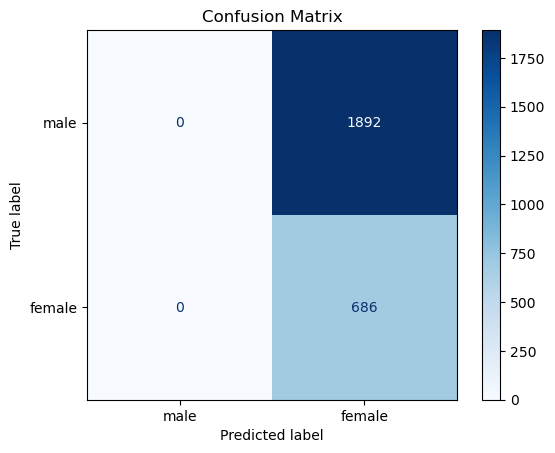

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(df['True Gender'], df['Predicted Gender'], labels=["male", "female"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["male", "female"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

# Save the figure with a specified DPI
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(df['True Gender'], df['Predicted Gender'])

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.27


#### Race Validation

In [2]:
import pandas as pd
data=pd.read_csv('Harvard Last Names/last_nameRaceProbs.csv', low_memory=False)
data = data.iloc[:-1, :]

In [3]:
# 1. Create a single column for the race label based on the highest probability
race_columns = ['whi', 'bla', 'his', 'asi', 'oth']
data['race'] = data[race_columns].idxmax(axis=1)
data

,name,whi,bla,his,asi,oth,race
0,A,0.042857,0.021429,0.000000,0.692857,0.242857,asi
1,AAB,1.000000,0.000000,0.000000,0.000000,0.000000,whi
2,AABEL,0.888889,0.000000,0.111111,0.000000,0.000000,whi
3,AABERG,0.940171,0.000000,0.000000,0.000000,0.059829,whi
4,AABYE,1.000000,0.000000,0.000000,0.000000,0.000000,whi
...,...,...,...,...,...,...,...
338163,ZYWICKI,0.825581,0.000000,0.133721,0.040698,0.000000,whi
338164,ZYWICS,1.000000,0.000000,0.000000,0.000000,0.000000,whi
338165,ZYWIOLEK,1.000000,0.000000,0.000000,0.000000,0.000000,whi
338166,ZYWNO,0.867925,0.000000,0.000000,0.000000,0.132075,whi


In [4]:
data.race.value_counts()

race
whi    259985
his     33337
bla     31007
asi     11728
oth      2111
Name: count, dtype: int64

In [5]:
# Define a mapping for renaming the values in the 'race' column
race_mapping = {
    'whi': 'White',
    'bla': 'Black',
    'his': 'hispanic',
    'asi': 'Asian or pacific islander',
    'oth': 'Other'
}
# Replace the values in the 'race' column
data['race'] = data['race'].replace(race_mapping)

In [6]:
data

,name,whi,bla,his,asi,oth,race
0,A,0.042857,0.021429,0.000000,0.692857,0.242857,Asian or pacific islander
1,AAB,1.000000,0.000000,0.000000,0.000000,0.000000,White
2,AABEL,0.888889,0.000000,0.111111,0.000000,0.000000,White
3,AABERG,0.940171,0.000000,0.000000,0.000000,0.059829,White
4,AABYE,1.000000,0.000000,0.000000,0.000000,0.000000,White
...,...,...,...,...,...,...,...
338163,ZYWICKI,0.825581,0.000000,0.133721,0.040698,0.000000,White
338164,ZYWICS,1.000000,0.000000,0.000000,0.000000,0.000000,White
338165,ZYWIOLEK,1.000000,0.000000,0.000000,0.000000,0.000000,White
338166,ZYWNO,0.867925,0.000000,0.000000,0.000000,0.132075,White


In [20]:
# Randomly select 100,00 rows
df = data.sample(n=10000, random_state=42)  # Set random_state for reproducibility
df=df[['name','race']].copy()
df

,name,race
124398,HANDE,White
254774,ROHE,White
205172,MOODHARD,White
135471,HOUX,White
166994,LAMPTON,White
...,...,...
153623,KINNA,White
120670,GUILLIOT,White
80054,DONCASTER,White
255630,RONDAN,hispanic


In [21]:
from tqdm import tqdm
# Enable tqdm for pandas apply
tqdm.pandas()

df['Predicted Race']=df['name'].progress_apply(lambda x: predict_race(x))
df

100%|██████████| 10000/10000 [01:05<00:00, 152.51it/s]


,name,race,Predicted Race
124398,HANDE,White,White
254774,ROHE,White,White
205172,MOODHARD,White,White
135471,HOUX,White,White
166994,LAMPTON,White,White
...,...,...,...
153623,KINNA,White,White
120670,GUILLIOT,White,White
80054,DONCASTER,White,White
255630,RONDAN,hispanic,White


In [22]:
df['Predicted Race'].value_counts()

Predicted Race
White                        9393
Hispanic                      332
Asian or pacific islander     148
Black                          84
Other                          40
Indian or alaskanative          3
Name: count, dtype: int64

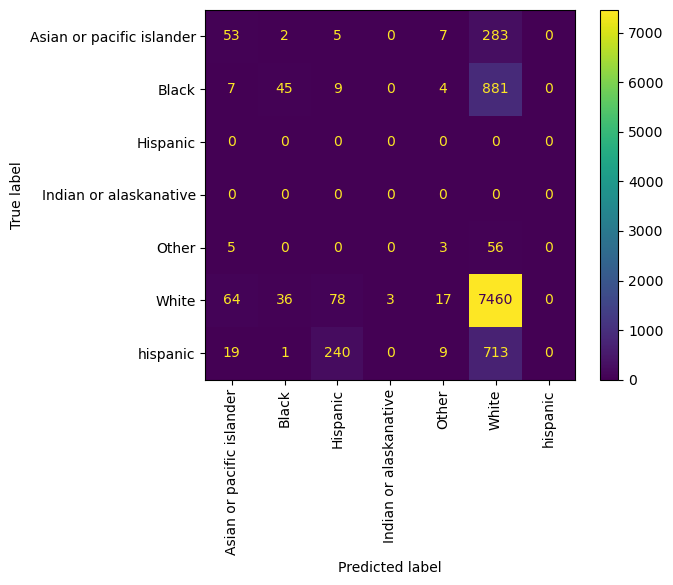

Accuracy: 0.76


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the unique labels in both true and predicted values
labels = sorted(set(df['race']).union(set(df['Predicted Race'])))

# Generate the confusion matrix
cm = confusion_matrix(df['race'], df['Predicted Race'], labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', xticks_rotation='vertical')

# Show the plot
import matplotlib.pyplot as plt
plt.show()

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(df['race'], df['Predicted Race'])

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

The overall accuracy of this model is 0.76. However, the model is expected to perform better with surnames commonly found in the USA, as it has been trained using U.S.-specific surnames. This methodology can be adapted to train the model with regional or country-specific surnames for improved performance. The Harvard race dataset includes surnames from various regions, which explains the current accuracy of 0.76. We believe that tailoring the training dataset to a specific region or country could significantly enhance performance.

~ Author: Khondhaker Al Momin